# Imports necessários

In [1]:
import numpy as np
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
%matplotlib inline

# Conexão e query's

### Conexão com o DB

In [3]:
def connect_db():
    load_dotenv()  # carrega as variáveis de ambiente do arquivo .env

    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    global cnxn
    if 'cnxn' in globals():
        try:
            cnxn.close()
            print('Conexão anterior fechada com sucesso.')
            return None
        except Exception as e:
            print(f'Não foi possível fechar a conexão anterior. Erro: {e}')

    try:
        cnxn = pyodbc.connect(f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}")
        print('Conexão bem sucedida.')
        return cnxn
    except Exception as err:
        print(f'Conexão mal sucedida. Erro {err}')
        return None

### Querys de busca no DB

In [4]:
query_get_data_receitas = 'SELECT * FROM dbo.Fato_Receita'

# Import dos dados constantes no DW

## Dados sobre as Receitas

In [5]:
df_receitas = pd.read_sql(query_get_data_receitas, connect_db())
connect_db()
df_receitas

Conexão bem sucedida.


C:\Users\allys\AppData\Local\Temp\ipykernel_56608\1582883830.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_receitas = pd.read_sql(query_get_data_receitas, connect_db())


Conexão anterior fechada com sucesso.


,id,uid_fato_receita,cod_receita,data_fato,contribuinte_receita,valor
0,1,229F9CDC-2494-4933-B43E-9ADD784F01B1,1722010101,2013-01-03,886cd0eabf5a18,185560.68
1,2,B8D6B25C-8928-4887-B189-0D9B5D17E11D,1722010101,2013-01-04,886cd0eabf5a18,8081.80
2,3,F63D84B9-0BF1-46AD-B381-AF189BF428BF,1722010101,2013-01-07,886cd0eabf5a18,4231.39
3,4,F645121D-AA82-4EDB-8A86-7F41154D65AF,1722010101,2013-01-08,886cd0eabf5a18,10536.53
4,5,28DE0FD1-6032-4A2C-B16F-F250E9B31DD1,1722010101,2013-01-15,886cd0eabf5a18,103118.27
...,...,...,...,...,...,...
102288,102289,EF8465D6-48C6-44C8-9741-FEB45515F37B,191101011,2022-01-19,e6da541375c18b,4374.24
102289,102290,DEDC9308-3ED5-498A-A904-E9551AC67411,112101011,2022-01-18,e6da541375c18b,228.00
102290,102291,1DDFCD5B-3F8A-4C08-B899-4331C5011C02,191101011,2022-01-18,e6da541375c18b,3758.69
102291,102292,CC42EB8D-FF4C-4126-81A9-01FE36DF882D,112101011,2022-01-17,e6da541375c18b,4297.00


In [6]:
df_receitas_copy = df_receitas[['cod_receita','data_fato','contribuinte_receita','valor']].copy()
df_receitas_copy['ano'] = df_receitas_copy['data_fato'].dt.year
df_receitas_copy['mes'] = df_receitas_copy['data_fato'].dt.month
df_receitas_copy['dia'] = df_receitas_copy['data_fato'].dt.day
df_receitas_copy['mes_ano'] = df_receitas_copy['data_fato'].dt.strftime('%m-%Y')
df_receitas_copy

,cod_receita,data_fato,contribuinte_receita,valor,ano,mes,dia,mes_ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013,1,3,01-2013
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,2013,1,4,01-2013
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,2013,1,7,01-2013
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,2013,1,8,01-2013
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,2013,1,15,01-2013
...,...,...,...,...,...,...,...,...
102288,191101011,2022-01-19,e6da541375c18b,4374.24,2022,1,19,01-2022
102289,112101011,2022-01-18,e6da541375c18b,228.00,2022,1,18,01-2022
102290,191101011,2022-01-18,e6da541375c18b,3758.69,2022,1,18,01-2022
102291,112101011,2022-01-17,e6da541375c18b,4297.00,2022,1,17,01-2022


## Definindo características dos gráficos

In [7]:
def plotar(titulo,labelx,labely,valorx,valory,dataset):
    sns.set_palette('Accent')
    sns.set_style('darkgrid')
    ax = sns.lineplot(x=valorx,y=valory, data=dataset)
    ax.figure.set_size_inches(12,6)
    ax.set_title(titulo,loc='left',fontsize=18)
    ax.set_xlabel(labelx,fontsize=14)
    ax.set_ylabel(labely,fontsize=14)
    ax=ax

In [8]:
def plot_comparacao(x,y1,y2,y3,dataset,titulo):
    plt.figure(figsize=(16,12))
    ax=plt.subplot(3,1,1)
    ax.set_title(titulo, fontsize=18,loc='left')
    sns.lineplot(x=x,y=y1,data=dataset)
    plt.subplot(3,1,2)
    sns.lineplot(x=x,y=y2,data=dataset)
    plt.subplot(3,1,3)
    sns.lineplot(x=x,y=y3,data=dataset)
    ax=ax

## Análise exploratória

### Verificação de valores ausentes na base de dados:

In [9]:
# Contagem de valores ausentes por coluna
print(df_receitas_copy.isnull().sum())

# Remoção dos valores ausentes
df_receitas_copy.dropna(inplace=True)

cod_receita             0
data_fato               0
contribuinte_receita    0
valor                   0
ano                     0
mes                     0
dia                     0
mes_ano                 0
dtype: int64


### Verificação de valores duplicados na base de dados:

In [10]:
# Contagem de linhas e colunas
print(f'Quantidade de linhas e colunas df original: {df_receitas.shape}')
print(f'Quantidade de linhas e colunas df cópia: {df_receitas_copy.shape}')

Quantidade de linhas e colunas df original: (102293, 6)
Quantidade de linhas e colunas df cópia: (102293, 8)


In [11]:
# Contagem de valores duplicados
print(f'Dados repetidos no df original: {df_receitas.duplicated().sum()}')
print(f'Dados repetidos no df cópia: {df_receitas_copy.duplicated().sum()}')
# Remoção dos valores duplicados
df_receitas_copy.drop_duplicates(inplace=True)

Dados repetidos no df original: 0
Dados repetidos no df cópia: 3543


### Análise descritiva com as informações do df:

In [12]:
df_receitas.describe().style.format('{:.2f}')

,id,cod_receita,valor
count,102293.00,102293.00,102293.00
mean,51147.00,1256925298.43,12522.46
std,29529.59,1162115226.37,89618.73
min,1.00,111250011.00,-2489288.55
25%,25574.00,1113034100.00,51.23
50%,51147.00,1121250000.00,240.60
75%,76720.00,1325000001.00,1579.25
max,102293.00,9728013100.00,4674330.00


In [13]:
df_receitas_copy.describe().style.format('{:.2f}')

,cod_receita,valor,ano,mes,dia
count,98750.00,98750.00,98750.00,98750.00,98750.00
mean,1260179621.58,12903.15,2017.34,6.69,17.51
std,1174354464.10,91168.16,2.71,3.46,9.53
min,111250011.00,-2489288.55,2013.00,1.00,1.00
25%,1113031100.00,55.99,2015.00,4.00,10.00
50%,1121250000.00,255.50,2017.00,7.00,18.00
75%,1325000001.00,1631.31,2020.00,10.00,27.00
max,9728013100.00,4674330.00,2022.00,12.00,31.00


### Verificação da distribuição dos valores da variável alvo (valores de receita municipal):

<Axes: xlabel='valor', ylabel='Density'>

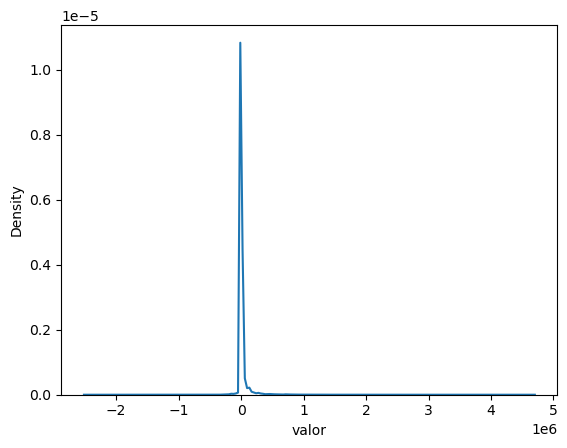

In [14]:
# Gráfico de densidade
sns.kdeplot(df_receitas_copy['valor'])

### Análise da correlação entre as variáveis utilizando a matriz de correlação e gráficos de dispersão

C:\Users\allys\AppData\Local\Temp\ipykernel_56608\2859652201.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_receitas_copy.corr()


<Axes: >

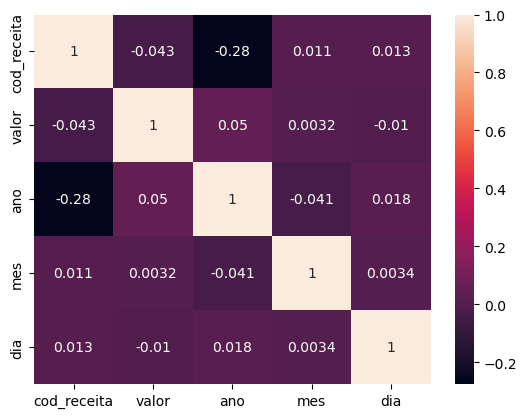

In [15]:
# Matriz de correlação
corr_matrix = df_receitas_copy.corr()
sns.heatmap(corr_matrix, annot=True)

<Axes: xlabel='ano', ylabel='valor'>

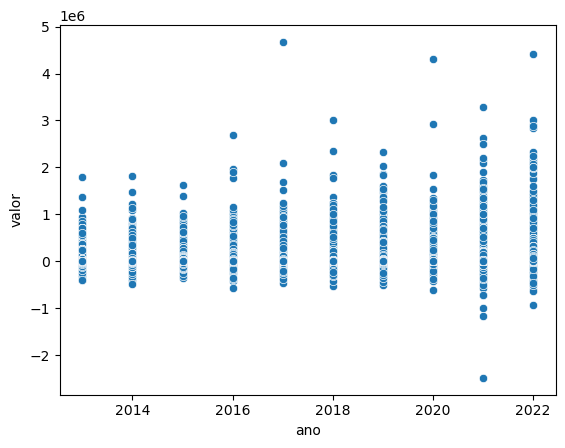

In [16]:
# Gráfico de dispersão
sns.scatterplot(x='ano', y='valor', data=df_receitas_copy)

<Axes: xlabel='mes', ylabel='valor'>

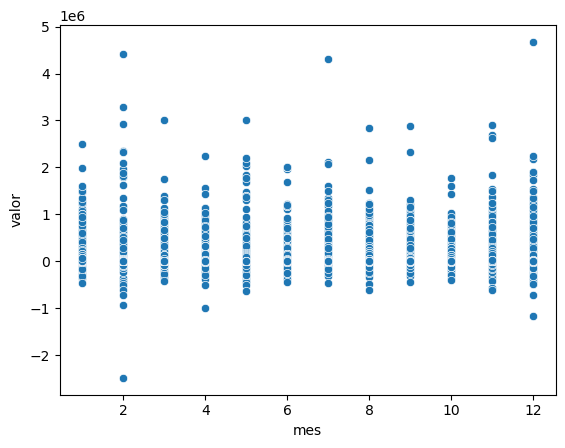

In [17]:
# Gráfico de dispersão
sns.scatterplot(x='mes', y='valor', data=df_receitas_copy)

<Axes: xlabel='dia', ylabel='valor'>

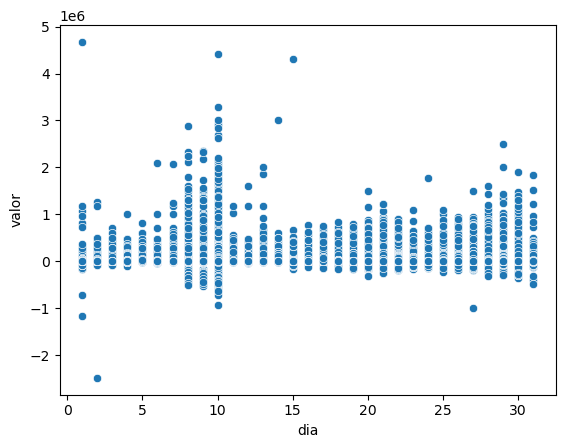

In [18]:
# Gráfico de dispersão
sns.scatterplot(x='dia', y='valor', data=df_receitas_copy)

<Axes: xlabel='cod_receita', ylabel='valor'>

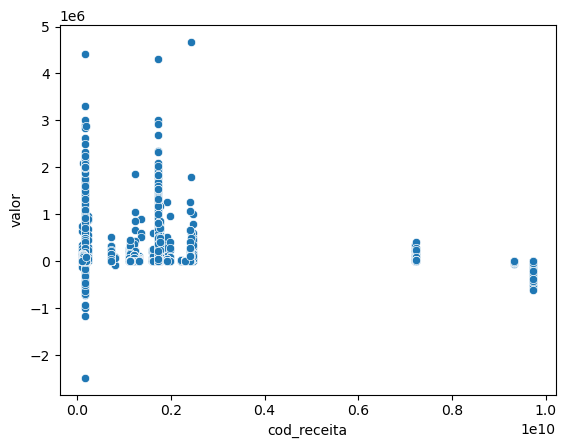

In [19]:
# Gráfico de dispersão
sns.scatterplot(x='cod_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='contribuinte_receita', ylabel='valor'>

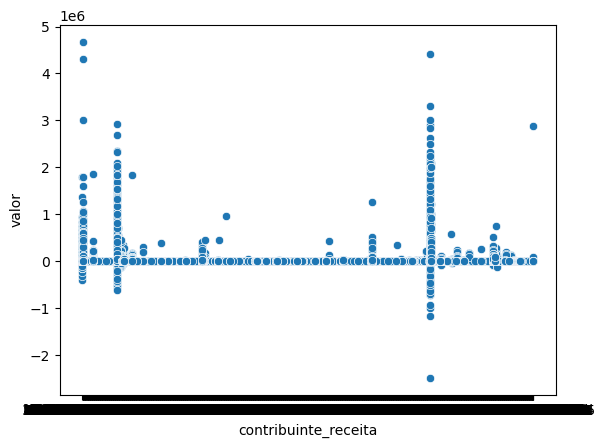

In [20]:
# Gráfico de dispersão
sns.scatterplot(x='contribuinte_receita', y='valor', data=df_receitas_copy)

### Verificação da presença de outliers:

<Axes: xlabel='valor'>

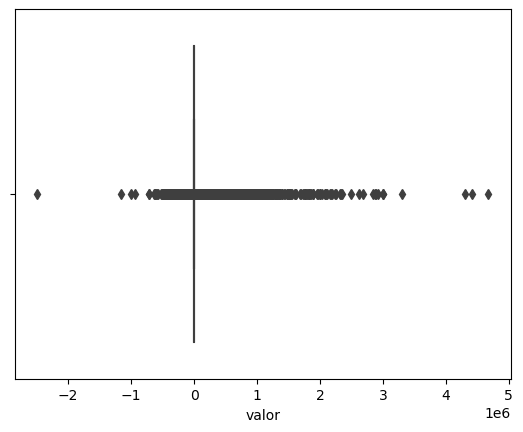

In [21]:
# Boxplot
sns.boxplot(x=df_receitas_copy['valor'])

<Axes: xlabel='ano', ylabel='valor'>

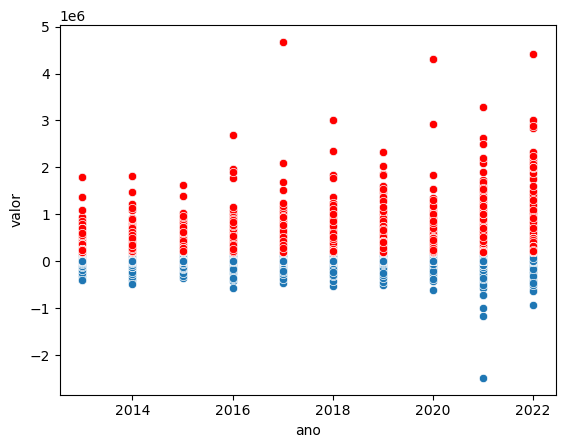

In [22]:
# Cálculo do threshold
threshold = np.mean(df_receitas_copy['valor']) + 2*np.std(df_receitas_copy['valor'])

# Gráfico de dispersão com pontos identificando os outliers
sns.scatterplot(x='ano', y='valor', data=df_receitas_copy)
sns.scatterplot(x=df_receitas_copy[df_receitas_copy['valor'] > threshold]['ano'], y=df_receitas_copy[df_receitas_copy['valor'] > threshold]['valor'], color='red')

### Verificação da distribuição das variáveis categóricas:

In [23]:
# Tabela de frequência
df_receitas_copy.groupby('contribuinte_receita').size()

contribuinte_receita
003049da08d3f8    1
0092a3488bcfb5    1
00afe72ed3d02e    4
0105fc482311ad    1
01489a24fb8fcf    2
                 ..
ff2cbd4aeb9c19    5
ff5b51a789b79b    6
ff6395491463ed    6
ffaca42fd6e45b    1
ffcea22fc174fc    3
Length: 1566, dtype: int64

<Axes: xlabel='contribuinte_receita', ylabel='count'>

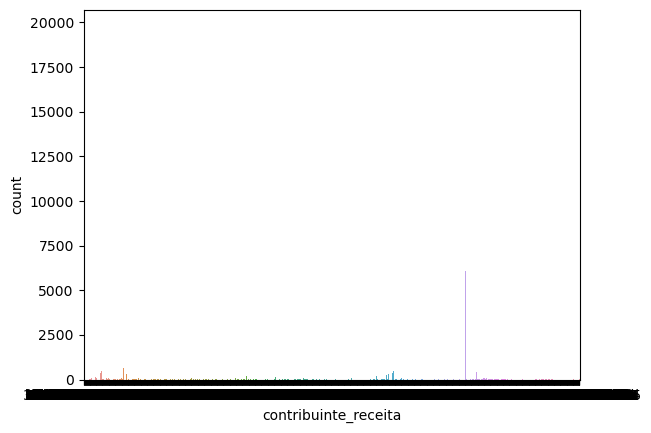

In [24]:
# Gráfico de barras
sns.countplot(x='contribuinte_receita', data=df_receitas_copy)

<Axes: xlabel='cod_receita', ylabel='count'>

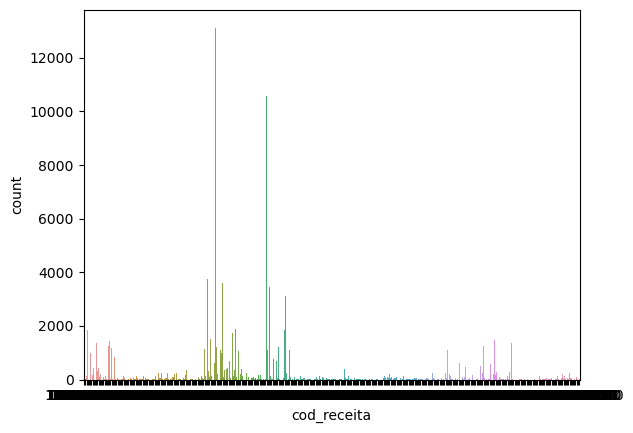

In [25]:
# Gráfico de barras
sns.countplot(x='cod_receita', data=df_receitas_copy)

### Análise da relação entre a variável alvo e as variáveis categóricas:

<Axes: xlabel='cod_receita', ylabel='valor'>

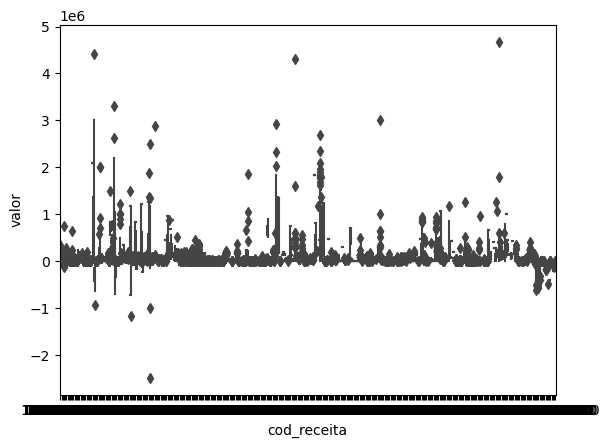

In [26]:
# Boxplot
sns.boxplot(x='cod_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='contribuinte_receita', ylabel='valor'>

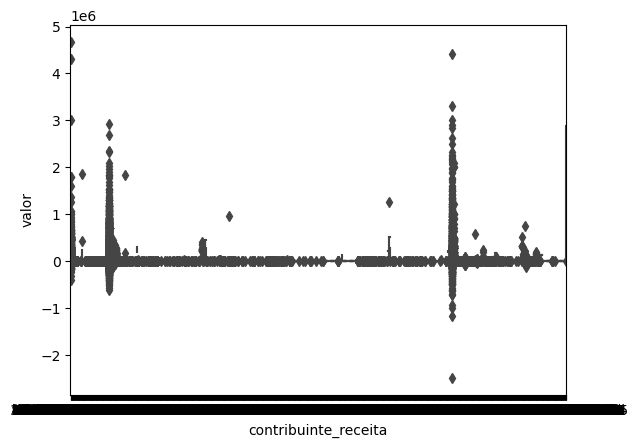

In [27]:
# Boxplot
sns.boxplot(x='contribuinte_receita', y='valor', data=df_receitas_copy)

<Axes: xlabel='ano', ylabel='valor'>

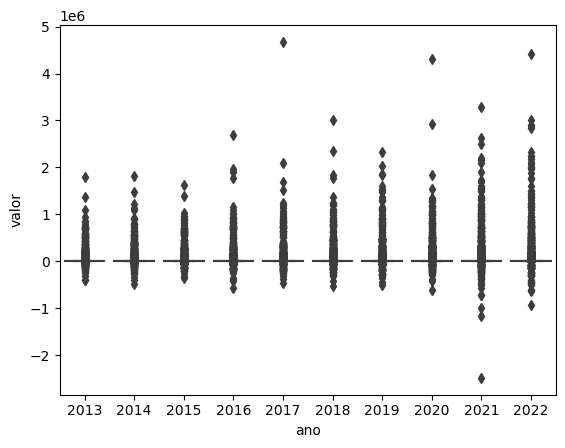

In [28]:
# Boxplot
sns.boxplot(x='ano', y='valor', data=df_receitas_copy)

<Axes: xlabel='mes', ylabel='valor'>

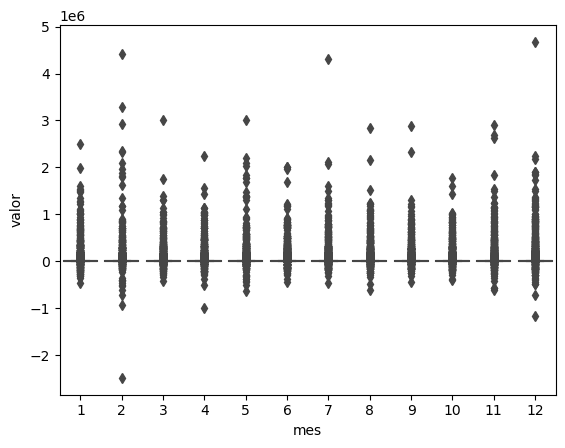

In [29]:
# Boxplot
sns.boxplot(x='mes', y='valor', data=df_receitas_copy)

<Axes: xlabel='dia', ylabel='valor'>

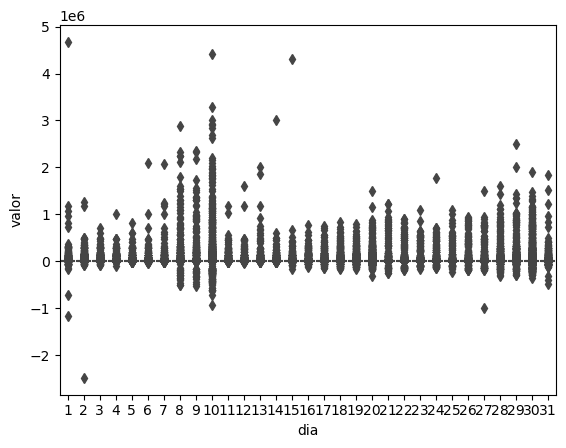

In [30]:
# Boxplot
sns.boxplot(x='dia', y='valor', data=df_receitas_copy)

In [31]:
# Teste de ANOVA
# Remover linhas com valores ausentes
df_receitas_clean = df_receitas_copy.dropna()

# Realizar o teste ANOVA para as variáveis categóricas

groups = []
for code in df_receitas_clean['cod_receita'].unique():
    group = df_receitas_clean[df_receitas_clean['cod_receita'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 186.53962131637732
p-value: 0.0


In [32]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['contribuinte_receita'].unique():
    group = df_receitas_clean[df_receitas_clean['contribuinte_receita'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 2.183828439679764
p-value: 8.923906789228629e-136


In [33]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['ano'].unique():
    group = df_receitas_clean[df_receitas_clean['ano'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 40.01728812418291
p-value: 5.847470420979971e-72


In [34]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['mes'].unique():
    group = df_receitas_clean[df_receitas_clean['mes'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 1.3512821624376834
p-value: 0.18882400683394612


In [35]:
# Realizar o teste ANOVA para as variáveis categóricas
groups = []
for code in df_receitas_clean['dia'].unique():
    group = df_receitas_clean[df_receitas_clean['dia'] == code]['valor']
    groups.append(group)
    
fvalue, pvalue = stats.f_oneway(*groups)
print('F-value:', fvalue)
print('p-value:', pvalue)

F-value: 16.01745106718474
p-value: 1.9738070655107013e-82


### Análise da distribuição dos valores da variável alvo em relação ao tempo:

In [36]:
df_receitas_copy.head(1)

,cod_receita,data_fato,contribuinte_receita,valor,ano,mes,dia,mes_ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013,1,3,01-2013


<Axes: xlabel='dia', ylabel='Count'>

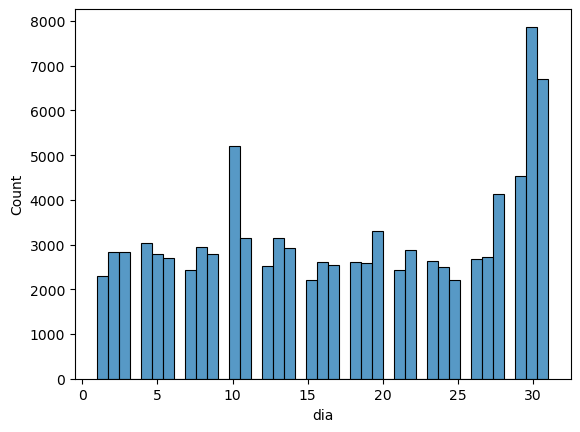

In [37]:
# Histograma por dia, mês e ano
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['dia'])

<Axes: xlabel='mes', ylabel='Count'>

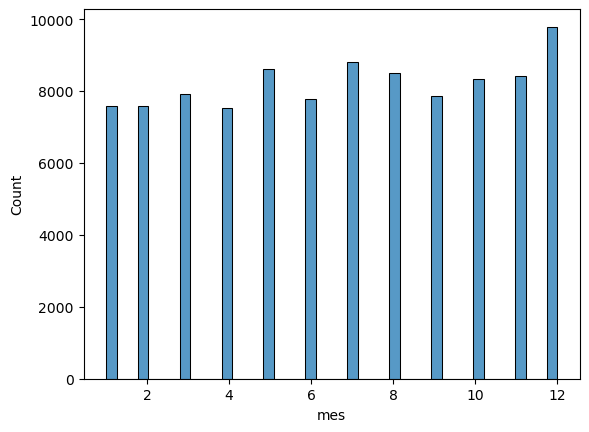

In [38]:
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['mes'])

<Axes: xlabel='ano', ylabel='Count'>

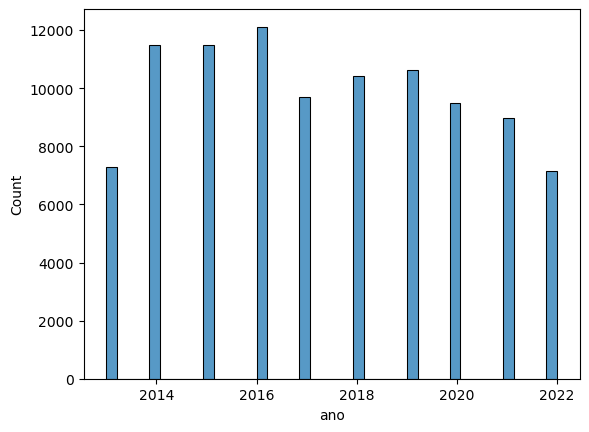

In [39]:
sns.histplot(df_receitas_copy['valor'], x=df_receitas_copy['ano'])

### Agrupando a receita por ano e somando os valores

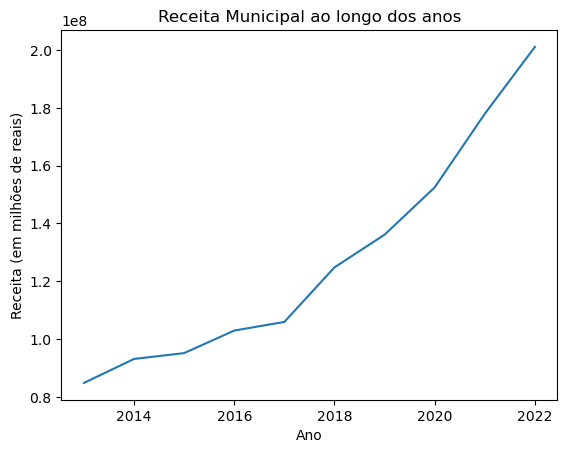

In [40]:
receita_por_ano = df_receitas_copy.groupby('ano')['valor'].sum()

# Plotando o gráfico de linha
plt.plot(receita_por_ano.index, receita_por_ano.values)
plt.title('Receita Municipal ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Receita (em milhões de reais)')
plt.show()

### Gráfico de linha com a média mensal da receita


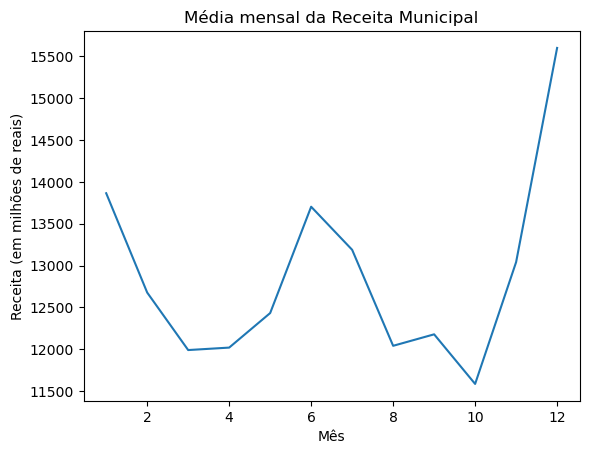

In [41]:
receita_por_mes = df_receitas_copy.groupby('mes')['valor'].mean()

# Plotando o gráfico de linha
plt.plot(receita_por_mes.index, receita_por_mes.values)
plt.title('Média mensal da Receita Municipal')
plt.xlabel('Mês')
plt.ylabel('Receita (em milhões de reais)')
plt.show()

### Gráfico de linha com a receita diária

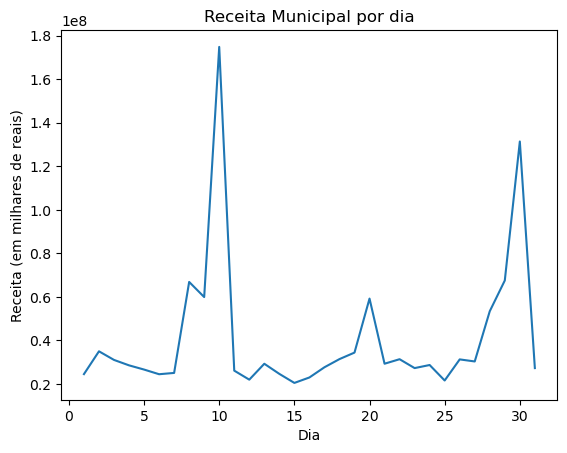

In [42]:
receita_por_dia = df_receitas_copy.groupby('dia')['valor'].sum()

# Plotando o gráfico de linha
plt.plot(receita_por_dia.index, receita_por_dia.values)
plt.title('Receita Municipal por dia')
plt.xlabel('Dia')
plt.ylabel('Receita (em milhares de reais)')
plt.show()

## Times Series

In [43]:
df_receita_mes_ano = df_receitas_copy[['valor','mes_ano']].copy()
df_receita_mes_ano.head()

,valor,mes_ano
0,185560.68,01-2013
1,8081.80,01-2013
2,4231.39,01-2013
3,10536.53,01-2013
4,103118.27,01-2013


In [44]:
df_receita_mes_ano['mes_ano'] = pd.to_datetime(df_receita_mes_ano['mes_ano'], format='%m-%Y')
df_receita_mes_ano.head()

,valor,mes_ano
0,185560.68,2013-01-01
1,8081.80,2013-01-01
2,4231.39,2013-01-01
3,10536.53,2013-01-01
4,103118.27,2013-01-01


In [45]:
df_grouped = df_receita_mes_ano.groupby(pd.Grouper(key='mes_ano')).sum()
df_grouped.reset_index(inplace=True)
df_grouped.rename(columns={'valor_mensal': 'valor_agrupado'}, inplace=True)

df_merged = pd.merge(df_receita_mes_ano, df_grouped, on='mes_ano')
df_merged.drop(columns={'valor_x'}, inplace=True)
df_merged.drop_duplicates(subset='mes_ano', inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.rename(columns={'valor_y':'valor_mensal'}, inplace=True)
df_receita_mes_ano = df_merged.copy()

In [46]:
df_receita_mes_ano

,mes_ano,valor_mensal
0,2013-01-01,5855243.48
1,2013-02-01,6977997.85
2,2013-03-01,6003101.60
3,2013-04-01,6033704.83
4,2013-05-01,6558550.11
...,...,...
115,2022-05-01,17872926.83
116,2022-04-01,13217971.69
117,2022-03-01,15360587.35
118,2022-02-01,14791870.57


In [47]:
df_receita_mes_ano['diferenca_receita_mensal'] = df_receita_mes_ano['valor_mensal'].diff()
df_receita_mes_ano

,mes_ano,valor_mensal,diferenca_receita_mensal
0,2013-01-01,5855243.48,NaN
1,2013-02-01,6977997.85,1122754.37
2,2013-03-01,6003101.60,-974896.25
3,2013-04-01,6033704.83,30603.23
4,2013-05-01,6558550.11,524845.28
...,...,...,...
115,2022-05-01,17872926.83,-6654006.75
116,2022-04-01,13217971.69,-4654955.14
117,2022-03-01,15360587.35,2142615.66
118,2022-02-01,14791870.57,-568716.78


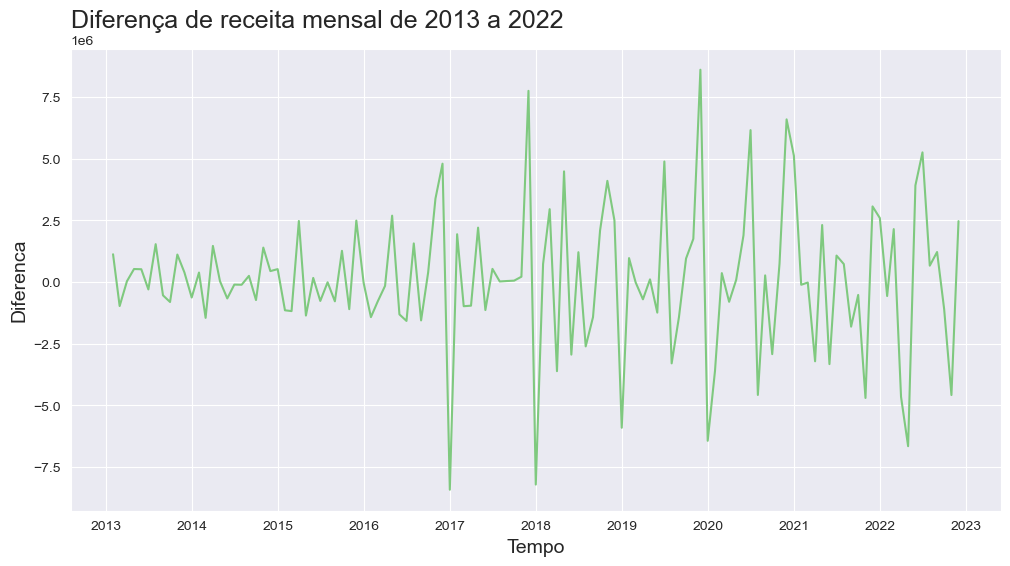

In [48]:
plotar('Diferença de receita mensal de 2013 a 2022','Tempo','Diferenca','mes_ano','diferenca_receita_mensal',df_receita_mes_ano)

In [49]:
df_receita_mes_ano['aceleracao_diferenca_receita_mensal'] = df_receita_mes_ano['diferenca_receita_mensal'].diff()
df_receita_mes_ano

,mes_ano,valor_mensal,diferenca_receita_mensal,aceleracao_diferenca_receita_mensal
0,2013-01-01,5855243.48,NaN,NaN
1,2013-02-01,6977997.85,1122754.37,NaN
2,2013-03-01,6003101.60,-974896.25,-2097650.62
3,2013-04-01,6033704.83,30603.23,1005499.48
4,2013-05-01,6558550.11,524845.28,494242.05
...,...,...,...,...
115,2022-05-01,17872926.83,-6654006.75,-10567709.39
116,2022-04-01,13217971.69,-4654955.14,1999051.61
117,2022-03-01,15360587.35,2142615.66,6797570.80
118,2022-02-01,14791870.57,-568716.78,-2711332.44


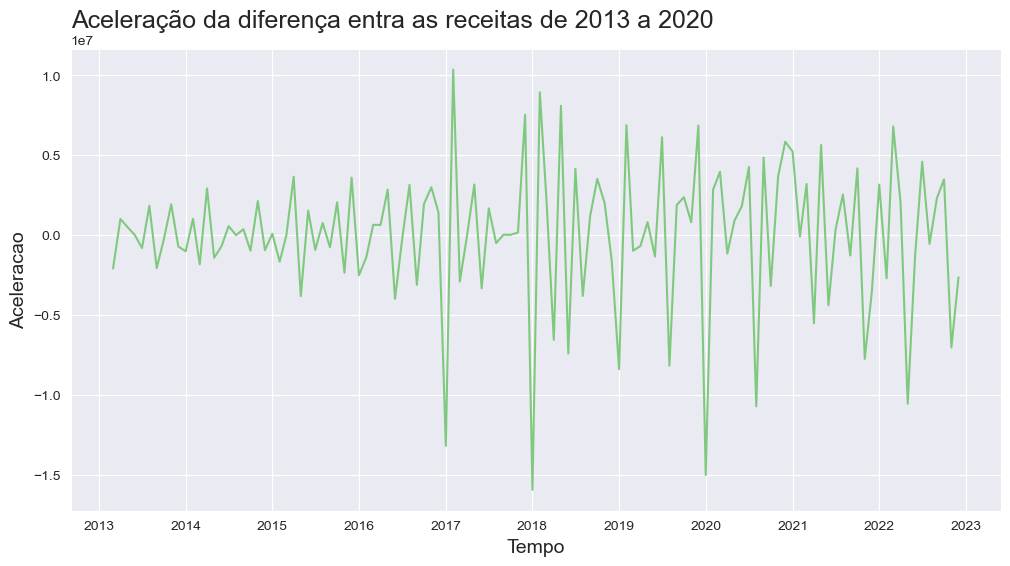

In [50]:
plotar('Aceleração da diferença entra as receitas de 2013 a 2020', 'Tempo','Aceleracao','mes_ano','aceleracao_diferenca_receita_mensal', df_receita_mes_ano)

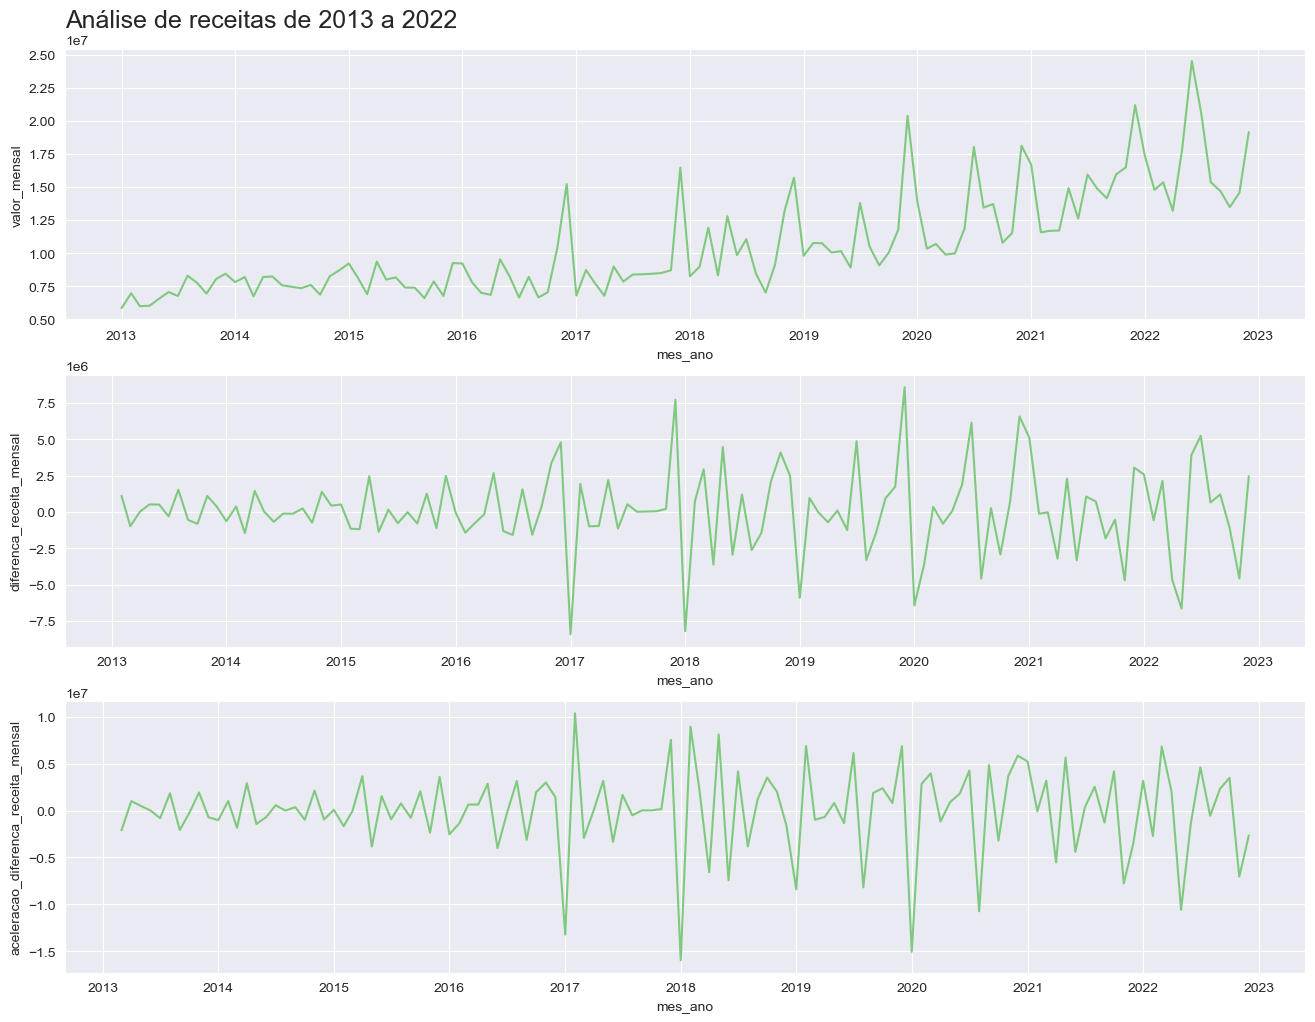

In [51]:
plot_comparacao('mes_ano','valor_mensal','diferenca_receita_mensal','aceleracao_diferenca_receita_mensal', df_receita_mes_ano,
                    'Análise de receitas de 2013 a 2022')

In [52]:
from pandas.plotting import autocorrelation_plot as atcp

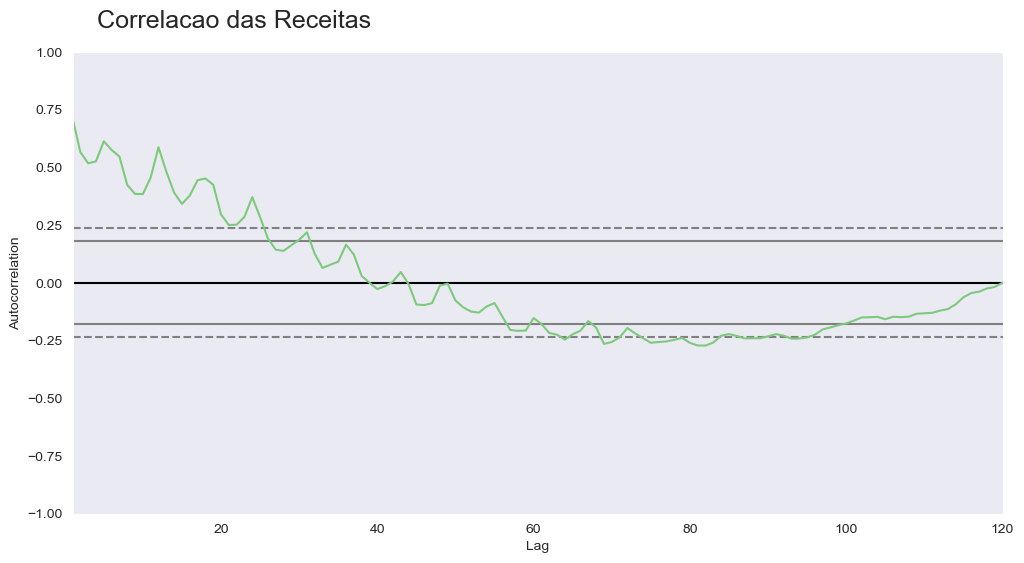

In [53]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Receitas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano['valor_mensal'])
ax=ax

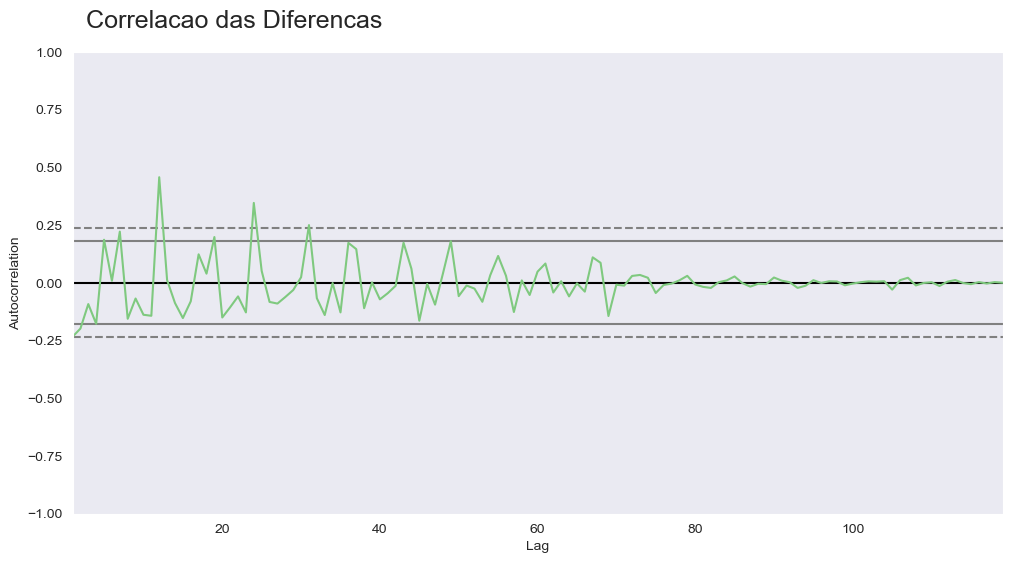

In [54]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao das Diferencas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano['diferenca_receita_mensal'][1:])
ax=ax

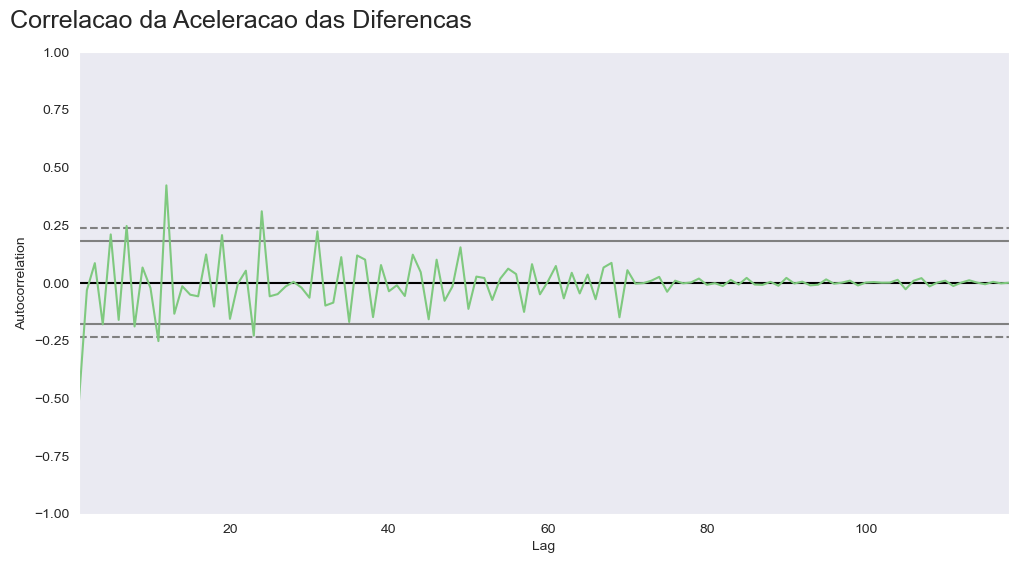

In [55]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlacao da Aceleracao das Diferencas', fontsize=18, x=0.26,y=0.95)
atcp(df_receita_mes_ano['aceleracao_diferenca_receita_mensal'][2:])
ax=ax

## Análise regressiva

### 1.Regressão Linear

#### Transformando variáveis categóricas em dummies

In [56]:
# # Transformando a variável categórica em variáveis dummy
# dummies = pd.get_dummies(df_receitas_copy['contribuinte_receita'])
# df_receitas_copy = pd.concat([df_receitas_copy, dummies], axis=1)

# # Removendo a coluna original 'codigo_receita'
# df_receitas_copy.drop('contribuinte_receita', axis=1, inplace=True)

# # Visualizando as primeiras linhas do DataFrame com as variáveis dummy
# df_receitas_copy

#### Definindo as variáveis independentes (y) e variável dependente(x)

In [57]:
df_receitas_copy.head(1)

,cod_receita,data_fato,contribuinte_receita,valor,ano,mes,dia,mes_ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013,1,3,01-2013


In [58]:
X = df_receitas_copy['ano']
y = df_receitas_copy['valor']

#### Dividindo o conjunto de dados em conjutos de treinamento e teste

#### Divisão dos dados em conjuntos de treinamento e teste

Neste trecho de código, estamos usando a função `train_test_split` da biblioteca Scikit-Learn para dividir o conjunto de dados em conjuntos de treinamento e teste. A função recebe como argumentos as variáveis independentes (X) e a variável dependente (y), bem como outros parâmetros opcionais.

Os parâmetros `test_size` e `random_state` são definidos na chamada da função e afetam a maneira como os dados são divididos em conjuntos de treinamento e teste. 

- `test_size`: define a proporção dos dados que serão utilizados para teste. Nesse caso, `test_size=0.2` significa que 20% dos dados serão usados para teste e 80% para treinamento.

- `random_state`: define uma semente aleatória para garantir que a divisão dos dados seja sempre a mesma, facilitando a reprodução dos resultados. Nesse caso, `random_state=42` é uma escolha comum, mas poderia ser qualquer outro valor.

A função `train_test_split` retorna quatro conjuntos de dados:

- `X_train`: conjunto de dados de treinamento para as variáveis independentes.
- `X_test`: conjunto de dados de teste para as variáveis independentes.
- `y_train`: conjunto de dados de treinamento para a variável dependente.
- `y_test`: conjunto de dados de teste para a variável dependente.

Esses conjuntos de dados são usados para treinar e testar o modelo de regressão. O conjunto de treinamento é usado para ajustar o modelo aos dados, enquanto o conjunto de teste é usado para avaliar o desempenho do modelo em dados novos e não vistos anteriormente.

É importante dividir os dados em conjuntos de treinamento e teste para evitar o overfitting, que ocorre quando o modelo é ajustado aos dados de treinamento de forma tão precisa que se torna incapaz de generalizar para novos dados. A divisão dos dados permite avaliar o desempenho do modelo em dados não utilizados para treinamento e ajustar os parâmetros do modelo para melhorar sua capacidade de generalização.


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Instanciando o modelo utilizado

#### Regressão Linear

In [60]:
# Transformando X_train e X_test em um array numpy bidimensional
X_train = X_train.values.reshape((-1, 1))
X_test = X_test.values.reshape((-1, 1))

In [61]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Utilizando o modelo para previsões nos dados de teste

In [62]:
y_pred = model.predict(X_test)

#### Avaliando o desempenho com coef. determinação (r2)

In [63]:
r2_score(y_test, y_pred)

0.0024681525122371983

In [64]:
model.score(X_test, y_test)

0.0024681525122371983